Select an example to run:
  1 - example1kinect.mat
  2 - example2kinect.mat
  3 - example3kinect.mat
  4 - example4kinect.mat
Enter number (1-4): 1


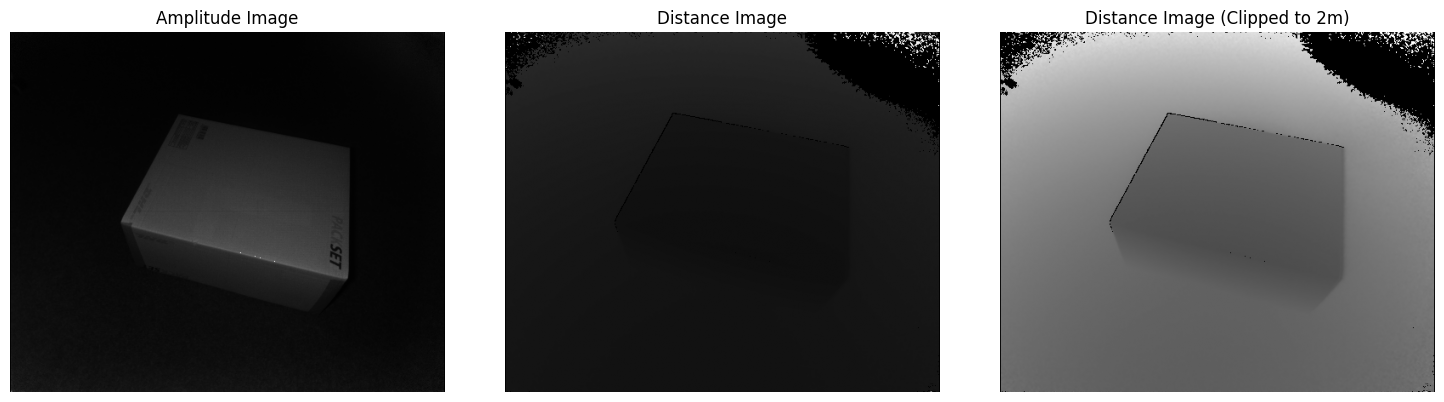

In [27]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.ndimage import label, binary_opening, binary_closing

# ------------------- Function: Select Example -------------------
def select_example():
    options = {
        "1": "example1kinect.mat",
        "2": "example2kinect.mat",
        "3": "example3kinect.mat",
        "4": "example4kinect.mat"
    }

    print("Select an example to run:")
    for k in options:
        print(f"  {k} - {options[k]}")

    choice = input("Enter number (1-4): ").strip()
    if choice not in options:
        raise ValueError("Invalid selection.")
    return options[choice]

# ------------------- Function: Load Data -------------------
def load_data(filepath):
    data = scipy.io.loadmat(filepath)
    amp_key = [k for k in data if k.startswith('amplitudes')][0]
    dist_key = [k for k in data if k.startswith('distances')][0]
    cloud_key = [k for k in data if k.startswith('cloud')][0]
    return data[amp_key], data[dist_key], data[cloud_key]

# ------------------- Start Script -------------------
filename = select_example()
A, D, PC = load_data(filename)

# ------------------- Step 2: Visualize Amplitude and Distance -------------------
plt.figure(figsize=(15, 4))

# Amplitude Image
plt.subplot(1, 3, 1)
plt.imshow(A, cmap='gray')
plt.title("Amplitude Image")
plt.axis('off')

# Raw Distance Image
plt.subplot(1, 3, 2)
plt.imshow(D, cmap='gray')
plt.title("Distance Image")
plt.axis('off')

# Clipped Distance Image (0–3m)
plt.subplot(1, 3, 3)
plt.imshow(np.clip(D, 0, 2), cmap='gray')
plt.title("Distance Image (Clipped to 2m)")
plt.axis('off')

plt.tight_layout()
plt.show()

Floor plane normal: [ 0.02623485 -0.58853415 -0.80804659]
Floor plane offset (d): 0.727899128129966
Number of inliers: 118887


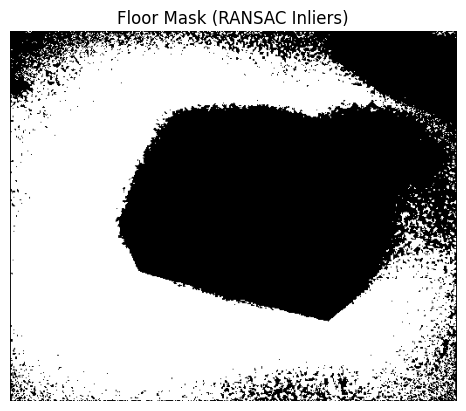

In [28]:
# ------------------- Step 3: RANSAC for Floor Plane -------------------
def ransac_plane_fit(points, threshold=0.01, max_iterations=500):
    best_inliers = []
    best_model = None
    num_points = points.shape[0]

    for _ in range(max_iterations):
        sample_indices = random.sample(range(num_points), 3)
        p1, p2, p3 = points[sample_indices]

        v1 = p2 - p1
        v2 = p3 - p1
        normal = np.cross(v1, v2)
        if np.linalg.norm(normal) == 0:
            continue
        normal = normal / np.linalg.norm(normal)
        d = -np.dot(normal, p1)

        distances = np.abs(points @ normal + d)
        inliers = np.where(distances < threshold)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (normal, d)

    return best_model, best_inliers

# Filter valid points (z != 0)
valid_mask = PC[:, :, 2] != 0
valid_points = PC[valid_mask]

# Fit RANSAC plane
model, inliers_idx = ransac_plane_fit(valid_points, threshold=0.01, max_iterations=500)
normal, d = model

# Assign for later use in box height calculation
floor_normal = normal
floor_d = d

print(f"Floor plane normal: {normal}")
print(f"Floor plane offset (d): {d}")
print(f"Number of inliers: {len(inliers_idx)}")

# ------------------- Step 4: Create Floor Mask -------------------
# Rebuild the mask into 2D image shape
floor_mask_flat = np.zeros(valid_points.shape[0], dtype=np.uint8)
floor_mask_flat[inliers_idx] = 1

# Reinsert into full image size
floor_mask_image = np.zeros_like(valid_mask, dtype=np.uint8)
floor_mask_image[valid_mask] = floor_mask_flat

# Show mask
plt.imshow(floor_mask_image, cmap='gray')
plt.title("Floor Mask (RANSAC Inliers)")
plt.axis('off')
plt.show()

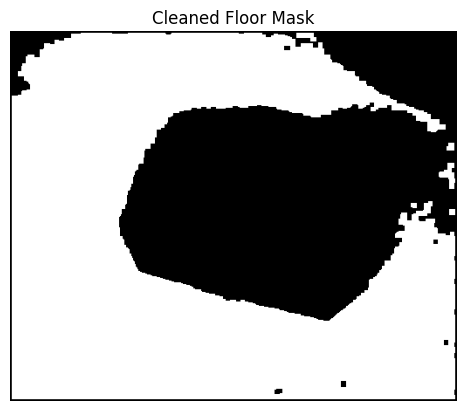

In [29]:
# Morphological filtering of floor mask
cleaned_floor_mask = binary_closing(floor_mask_image, structure=np.ones((5, 5)))
cleaned_floor_mask = binary_opening(cleaned_floor_mask, structure=np.ones((5, 5)))

plt.imshow(cleaned_floor_mask, cmap='gray')
plt.title("Cleaned Floor Mask")
plt.axis('off')
plt.show()

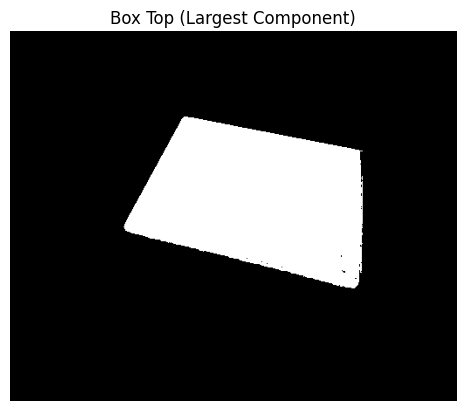

In [30]:
# ------------------- Step 5: Top Plane Detection -------------------
non_floor_mask = (valid_mask.astype(bool) & ~floor_mask_image.astype(bool))
non_floor_points = PC[non_floor_mask]
box_model, box_inliers_idx = ransac_plane_fit(non_floor_points, threshold=0.01, max_iterations=500)
box_normal, box_d = box_model

box_mask_flat = np.zeros(non_floor_points.shape[0], dtype=np.uint8)
box_mask_flat[box_inliers_idx] = 1
box_top_mask_image = np.zeros_like(valid_mask, dtype=np.uint8)
box_top_mask_image[non_floor_mask] = box_mask_flat

labeled, num_features = label(box_top_mask_image)
largest_component_label = np.argmax(np.bincount(labeled.ravel())[1:]) + 1
largest_component_mask = (labeled == largest_component_label)

plt.imshow(largest_component_mask, cmap='gray')
plt.title("Box Top (Largest Component)")
plt.axis('off')
plt.show()

In [31]:
# ------------------- Step 6: Box Size Estimation -------------------
box_top_points = PC[largest_component_mask]

# Adjust normal if opposite directions
if np.dot(floor_normal, box_normal) < 0:
    box_normal = -box_normal
    box_d = -box_d

height = abs(box_d - floor_d) / np.linalg.norm(floor_normal)
min_xyz = np.min(box_top_points, axis=0)
max_xyz = np.max(box_top_points, axis=0)
length = np.linalg.norm(max_xyz[[0, 1]] - min_xyz[[0, 1]])
width = np.max([abs(max_xyz[0] - min_xyz[0]), abs(max_xyz[1] - min_xyz[1])])

print(f"Estimated Box Dimensions:")
print(f"  Height: {height:.3f} m")
print(f"  Length (XY-diagonal): {length:.3f} m")
print(f"  Width (X/Y span): {width:.3f} m")

Estimated Box Dimensions:
  Height: 0.186 m
  Length (XY-diagonal): 0.651 m
  Width (X/Y span): 0.530 m


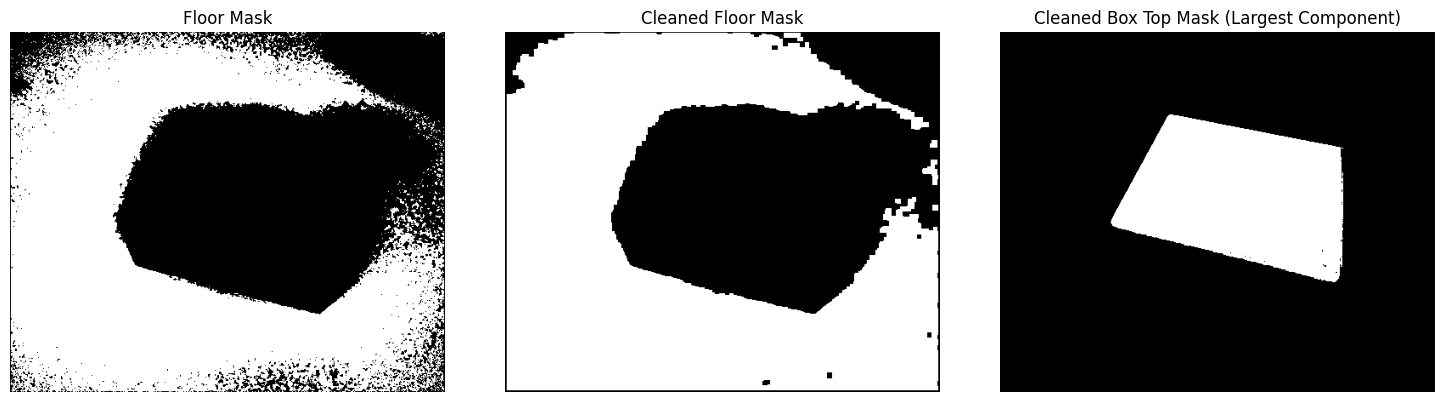

In [32]:
plt.figure(figsize=(15, 4))


plt.subplot(1, 3, 1)
plt.imshow(floor_mask_image, cmap='gray')
plt.title("Floor Mask")
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(cleaned_floor_mask, cmap='gray')
plt.title("Cleaned Floor Mask")
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(largest_component_mask, cmap='gray')
plt.title("Cleaned Box Top Mask (Largest Component)")
plt.axis('off')


plt.tight_layout()
plt.show()

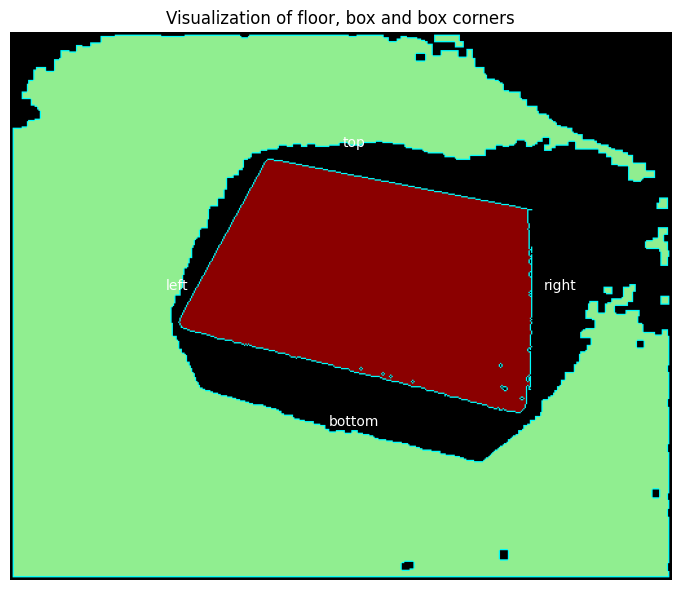

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from scipy.ndimage import label

# 1. Create RGB canvas
H, W = D.shape
rgb_img = np.zeros((H, W, 3), dtype=np.uint8)

# 2. Assign colors
rgb_img[cleaned_floor_mask > 0] = [144, 238, 144]  # light green
rgb_img[largest_component_mask > 0] = [139, 0, 0]  # dark red

# 3. Overlay edges
floor_edges = find_boundaries(cleaned_floor_mask, mode='inner')
box_edges = find_boundaries(largest_component_mask, mode='inner')
rgb_img[floor_edges | box_edges] = [0, 255, 255]  # cyan

# 4. Automatically compute bounding box
coords = np.argwhere(largest_component_mask)
ymin, xmin = coords.min(axis=0)
ymax, xmax = coords.max(axis=0)

# 5. Plot and label
plt.figure(figsize=(8, 6))
plt.imshow(rgb_img)
plt.title("Visualization of floor, box and box corners")

# Automatically position labels based on bounding box
plt.text((xmin + xmax) // 2, ymin - 10, 'top', color='white', fontsize=10, ha='center')
plt.text((xmin + xmax) // 2, ymax + 10, 'bottom', color='white', fontsize=10, ha='center')
plt.text(xmin - 10, (ymin + ymax) // 2, 'left', color='white', fontsize=10, va='center')
plt.text(xmax + 10, (ymin + ymax) // 2, 'right', color='white', fontsize=10, va='center')

plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
def compute_box_corners(mask, PC):
    labeled, _ = label(mask)
    largest = np.argmax(np.bincount(labeled.flat)[1:]) + 1
    comp = labeled == largest
    coords = np.argwhere(comp)
    xmin, ymin = coords.min(axis=0)
    xmax, ymax = coords.max(axis=0)
    return np.array([
        PC[xmin, ymin],
        PC[xmin, ymax],
        PC[xmax, ymin],
        PC[xmax, ymax]
    ])

def visualize_result(PC, floor_mask, top_mask, corners):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pc_flat = PC.reshape(-1, 3)

    floor_points = pc_flat[floor_mask.flatten()]
    top_points = pc_flat[top_mask.flatten()]

    # Subsample
    if len(floor_points) > 5000:
        floor_points = floor_points[np.random.choice(len(floor_points), 5000, replace=False)]
    if len(top_points) > 3000:
        top_points = top_points[np.random.choice(len(top_points), 3000, replace=False)]

    # Plot floor and box
    ax.scatter(floor_points[:, 0], floor_points[:, 1], floor_points[:, 2],
               s=0.5, c='blue', label='Floor', depthshade=False)
    ax.scatter(top_points[:, 0], top_points[:, 1], top_points[:, 2],
               s=0.5, c='red', label='Box Top', depthshade=True)

    # Plot corners with no depth shading
    for i, c in enumerate(corners):
        ax.scatter(*c, c='lime', s=120, marker='o', edgecolors='black',
                   linewidths=1.5, depthshade=False)
        ax.text(c[0], c[1], c[2] + 0.05, f'C{i+1}', color='black', fontsize=9)

    ax.legend()
    ax.set_title("Box and Floor Detection (Annotated)")
    plt.show()

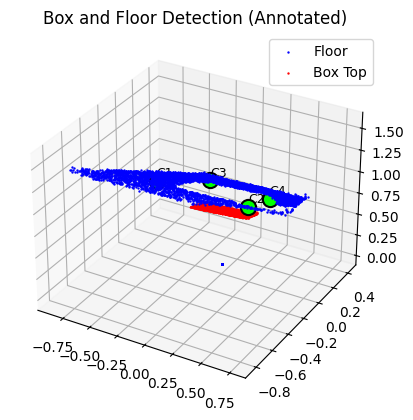

In [35]:
corners = compute_box_corners(largest_component_mask, PC)

visualize_result(PC, cleaned_floor_mask, largest_component_mask, corners)